# Getting started with HTRC Extracted Features

This tutorial will get you up-and-running with the HTRC Extracted Features dataset. Learn more about the data: https://wiki.htrc.illinois.edu/x/GoA5Ag

The code and instructions used in this notebook combine elements from a Programming Historian lesson called "Text Mining in Python through the HTRC Feature Reader" (https://programminghistorian.org/en/lessons/text-mining-with-extracted-features) and the Berkeley Data Science Module, "Library-HTRC" (https://github.com/ds-modules/Library-HTRC).


## Setup and reading in files

To get started, we need to import the Python modules we'll use throughout this notebook.

In [1]:
from htrc_features import FeatureReader
import matplotlib
import matplotlib.pyplot as plt
import numpy 
import pandas 
import glob

Extracted Featuers files are originally formatted in JSON notation and compressed; you'll notice the file format is '.json.bz2'. The FeatureReader library is able to work with the files in that format with needing to decompress the files.

Within the library, there is a **FeatureReader object** that is used for loading the dataset files and making sense of them. It returns a **Volume object** for each file. A Volume is a representation of a single item in HathiTrust, for example a book or other textual work. From the Volume, you can access features about the work. To drill down to the features derived from individual pages, use the **Page object**.

We'll need to get the FeatureReader ready to use by pointing it to the file paths for the sample Extracted Features files we are using in this notebook. The files are in directory called 'ef-data'. We'll be using the Extracted Features files four our workset of all 30 volumes of Josiah Conder's _The Modern Traveller_.
 
With fr = FeatureReader(paths) below, the FeatureReader is initialized, meaning it is ready to use. An initialized FeatureReader is holding references to the file paths that we gave it, and will load them into Volume objects when asked.

In [2]:
# create a list of file paths from ef-data directory and load the data in the Feature Reader

file_paths = glob.glob('ef-data/*.bz2') # glob is a library that will search a file path and return 
                                        # files with a given extension (format)
file_paths.sort(reverse=True)

print(file_paths)
    
fr_mt = FeatureReader(file_paths)

['ef-data/mdp.39015074624324.json.bz2', 'ef-data/mdp.39015074624316.json.bz2', 'ef-data/mdp.39015074624308.json.bz2', 'ef-data/mdp.39015074624290.json.bz2', 'ef-data/mdp.39015074624282.json.bz2', 'ef-data/mdp.39015074624274.json.bz2', 'ef-data/mdp.39015074624266.json.bz2', 'ef-data/mdp.39015074624258.json.bz2', 'ef-data/mdp.39015074623631.json.bz2', 'ef-data/mdp.39015074623623.json.bz2', 'ef-data/mdp.39015074623615.json.bz2', 'ef-data/mdp.39015074623607.json.bz2', 'ef-data/mdp.39015073768049.json.bz2', 'ef-data/mdp.39015073767934.json.bz2', 'ef-data/mdp.39015073767926.json.bz2', 'ef-data/mdp.39015073767918.json.bz2', 'ef-data/mdp.39015073767900.json.bz2', 'ef-data/mdp.39015073767884.json.bz2', 'ef-data/mdp.39015073767876.json.bz2', 'ef-data/mdp.39015073767868.json.bz2', 'ef-data/mdp.39015073767850.json.bz2', 'ef-data/mdp.39015073767843.json.bz2', 'ef-data/mdp.39015073767835.json.bz2', 'ef-data/mdp.39015073767827.json.bz2', 'ef-data/mdp.39015073767801.json.bz2', 'ef-data/mdp.39015073767

Let's see what titles have been loaded as Volumes. Because these are volumes within a larger work, they have the same basic title.

In [3]:
for vol in fr_mt.volumes():
    print(vol.title)

The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of the various countries of the globe. By Josiah Conder ...
The modern traveller; a description of t

## File and page structure

We can call just one Volume at a time in order to examine its contents. In this example, we are taking the first file.

In [4]:
vol = fr_mt.first()
vol

In [5]:
fr_mt.volumes

<bound method FeatureReader.volumes of <30 path FeatureReader (ef-data/mdp.39015074624324.json.bz2 to ef-data/mdp.39015073767215.json.bz2)>>

We can also call the URL for the volume and CTRL-click it to find the corresponding item in the HathiTrust Digital Library (HTDL). 

These volumes are in the public domain, so we will find that they are available for "Full View" in the HTDL. If they were still under copyright, we would be taken to a "Limited View" page. The Extracted Features dataset includes a snapshot of 15.7 million volumes from the HTDL and is agnostic to rights status, as the files represent data about the volumes. 

In [6]:
print(vol.handle_url)

http://hdl.handle.net/2027/mdp.39015074624324


Let's see what other metadata elements are available to you for each item in its corresponding Extracted Features file. Put your cursor between the period and the end parenthesis, and press tab. You can choose from the dropdown list. Then run the cell.

In [7]:
#Put your cursor between the period . and the end parenthesis ) and press tab. You can choose from the dropdown list.
print(vol.author)

['Conder, Josiah 1789-1855 ']


It's time to access the first features of vol, which is a table of total words for every single page. These can be accessed simply by calling vol.tokens_per_page().

In [8]:
tokens = vol.tokens_per_page()
# Show just the first few rows, so we can look at what it looks like
tokens.head()

,count
page,
1,0
2,0
3,0
4,0
5,41


This is a straightforward table of information, similar to what you would see in Excel or Google Spreadsheets. Listed in the table are page numbers and the count of words on each page. 

With only two dimensions, it is trivial to plot the number of words per page. The table structure holding the data has a plot method for data graphics. Without extra arguments, tokens.plot() will assume that you want a line chart with the page on the x-axis and word count on the y-axis.

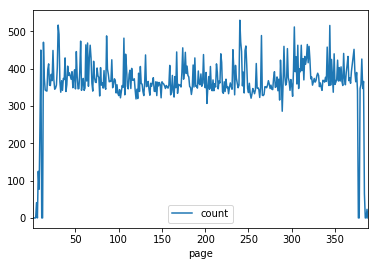

In [9]:
%matplotlib inline
tokens.plot()

How did we get here? When we ran vol.tokens_per_page(), it returned a Pandas DataFrame. This means that after setting tokens, we're no longer working with HTRC-specific code, just book data held in a common and very robust table-like construct from Pandas. tokens.head() used a DataFrame method to look at the first few rows of the dataset, and tokens.plot() uses a method from Pandas to visualize data.

## Loading a Token List
Another DataFrame accessible to us is `vol.tokenlist()`, which can be called to return section-, part-of-speech-, and word-specific details.

Let's use this method to look at some words deeper into the book: from 1000th to 1100th row, skipping by 15, denoted by `[1000:1100:15]`:

In [10]:
tl = vol.tokenlist()
tl[1000:1100:15]

count
page section token       pos       
15   body    India       NNP      1
             Paropamisan NNP      1
             admit       VB       1
             by          IN       4
             distance    NN       1
             in          IN       2
             miles       NNS      1

As before, the data is returned as a Pandas DataFrame. This time, there is much more information. The columns in bold are an index. Unlike the typical one-dimensional index seen before, here there are four dimensions to the index: page, section, token, and pos. This row says that for the 24th page, in the body section (i.e. ignoring any words in the header or footer), the word 'years' occurs 1 time as an plural noun. The part-of-speech tag for a plural noun, NNS, follows the Penn Treebank definition.

You can sort of see this as nested information, moving beyond how we might normally work with tabular or spreadsheet data. The blank cells are areas where the data would have normally been duplicated.

The HTRC Feature Reader refers to "pages" as the $n^{th}$ scanned image of the volume, not the actual number printed on the page. This is why, often, the first page may be the cover, or inside cover, or a blank page.

Tokenlists can be retrieved with arguments -- or the stuff that goes inside the `()` -- that combine information by certain dimensions, such as case, POS, or page. For example, `case=False` specified that "Jaguar" and "jaguar" should be counted together. You may also notice that, by default, only `body` is returned, a default that can be overridden.

Look at the following list of commands: can you guess what the output will look like? Try for yourself and observe how the output changes.

```python
vol.tokenlist(case=False)
vol.tokenlist(pos=False)
vol.tokenlist(pages=False, case=False, pos=False)
vol.tokenlist(section='header')
vol.tokenlist(section='group')
```

Details for these arguments are available in the code documentation for the Feature Reader or by running:

```python
vol.tokenlist?
```

## Working with DataFrames

The Pandas DataFrame type returned by the HTRC Feature Reader is very malleable. To work with the tokenlist that you retrieved earlier (`tl`), three skills are particularily valuable:

1. Selecting subsets by a condition
2. Slicing by named row index
3. Grouping and aggregating

### Selecting Subsets of a DataFrame by a Condition

Consider this example: *I only want to look at tokens that occur more than a hundred times in the book.* 

Remembering that the table-like output from the HTRC Feature Reader is a Pandas DataFrame, the way to pursue this goal is to learn to filter and subset DataFrames. Knowing how to do so is important for working with just the data that you need.

To subset individual rows of a DataFrame, you can provide a series of True/False values to the DataFrame, formatted in square brackets. When True, the DataFrame returns that row; when False, the row is excluded from what is returned.

To see this in context, first load a basic tokenlist without parts-of-speech or individual pages:

In [11]:
tl_simple = vol.tokenlist(pos=False, pages=False)
# .sample(5) returns five random words from the full result
tl_simple.sample(5)

count
section token           
body    physical       7
        urns           2
        opinion       14
        annoying       1
        disgraces      2

To select just the relevant tokens, we need to look at each row and evaluate whether it matches the criteria that "this token has a count greater than 100". Let's try to convert that requirement to code.

"This token has a count" means that we are concerned specifically with the 'count' column, which can be singled out from the `tl` table with `tl['count']`. "greater than 100" is formalized as `> 100`. Putting it together, try the following and see what you get:

```python
tl_simple['count'] > 100
```

It is a DataFrame of True/False values. Each value indicates whether the 'count' column in the corresponding row matches the criteria or not. We haven't selected a subset yet, we simply asked a question and were told for each row when the question was true or false.

> You may wonder why section and token are still seen, even though 'count' was selected. These are part of the DataFrame **index**, so they're considered part of the information *about* that row rather than data *in* the row. You can convert the index to data columns with `reset_index()`. In this lesson we will keep the index intact, though there are advanced cases where there are benefits to resetting it.

Armed with the True/False values of whether each token's 'count' value is or isn't greater than 100, we can give those values to `tl_simple` in square brackets:

In [12]:
matches = tl_simple['count'] > 100
tl_simple[matches].sample(5)

count
section token         
body    Malcolm    116
        into       237
        son        169
        made       141
        .         4761

You can move the comparison straight into the square brackets, the more conventional equivalent of the above:

In [13]:
tl_simple[tl_simple['count'] > 100].sample(5)

count
section token       
body    ;       1280
        been     362
        on       495
        more     210
        as       670

As might be expected, many of the tokens that occur very often are common words like "she" and "and", as well as various punctuation. 

Multiple conditions can be chained with `&` (and) or `|` (or), using regular brackets so that Python knows the order of operations. For example, words with a count greater than 150 *and* a count less than 200 are selected in this way:

In [14]:
tl_simple[(tl_simple['count'] > 150) & (tl_simple['count'] < 200)]

count
section token         
body    He         176
        In         199
        It         162
        being      153
        country    175
        death      154
        great      173
        has        177
        monarch    184
        no         156
        other      163
        some       172
        son        169
        than       175
        these      163
        two        153
        upon       199
        very       161
        we         184
        years      158

We'll practice slicing by named row index first.For example, we can add a word between the quotation marks to retrieve only pages where that word occurs. We are using the power of the DataFrame index to retrieve only the rows that match our criteria:

In [15]:
tl_all = vol.tokenlist(section='all')

# add a word between the quotes
chapter_pages = tl_all.loc[(slice(None), slice(None), 'desert'),]
chapter_pages

,,,,count
page,section,token,pos,
18,body,desert,NN,5
19,body,desert,NN,1
26,body,desert,NN,1
30,body,desert,NN,1
31,body,desert,NN,1
72,body,desert,NN,1
81,body,desert,NN,1
100,body,desert,NN,1
106,body,desert,NN,1


### Slicing DataFrames
It is also possible to select a DataFrame subset by specifying the values of its index, a process called **slicing**. For example, you can ask, *"give me all the verbs for pages 9-12"*.

In the DataFrame returned by `vol.tokenlist()`, page, section, token, and POS were part of the index (try the command `tl.index.names` to confirm). One can think of an index as the margin content of an Excel spreadsheet: the letters along the top and numbers along the left side are the indices. A cell can be referred to as A1, A2, B1... In Pandas, however, you can name these, so instead of A, B, C, or 1,2,3, columns and rows can be referred to by more descriptive names. You can also have multiple levels, so you're not bound by the two-dimensions of a table format. With a multi-indexed DataFrame, you can ask for `Page=24,section=Body, ...`.  One can think of an index as the margin notations in Excel (i.e. 1,2,3... and A,B,C,..), except it can be named and can have multiple levels.

Slicing a DataFrame against a labelled index is done using `DataFrame.loc[]`. Try the following examples and see what is returned:

- Select information from page 17: 
  - `tl.loc[(17),]`
- Select 'body' section of page 17:
  - `tl.loc[(17, 'body'),]`
- Select counts of the word 'Anne' in the 'body' section of page 17:
  - `tl.loc[(17, 'body', 'Anne'),]`

In [16]:
# use this code cell to try out the above examples



The levels of the index are specified in order, so in this case the first value refers to 'page', then 'section', and so on. To skip specifying anything for an index level -- that is, to select everything for that level -- `slice(None)` can be used as a placeholder:

- Select counts of the word 'Anne' for all pages and all page sections
  - `tl.loc[(slice(None), slice(None), "Anne"),]`
  
Finally, it is possible to select multiple labels for a level of the index, with a list of labels (i.e. `['label1', 'label2']`) or a sequence covering everything from one value to another (i.e. `slice(start, end)`):

- Select pages 37, 38, and 52
  - `tl.loc[([37, 38, 52]),]`
- Select all pages from 37 to 40
  - `tl.loc[(slice(37, 40)),]`
- Select counts for 'Anne' or 'Hilary' from all pages
  - `tl.loc[(slice(None), slice(None), ["Anne", "Hilary"]),]`

Knowing how to slice, let's try to find the sections in this book, and compare where that shows up to the token-per-page pattern previously plotted.

The token list we previously set to `tl` only included body text; to include headers and footers in a search, we could generate a tokenlist with `section='all'` specified. Since our workset, the volumes of Josiah Conder's _The Modern Traveller_, does not include chapter headings or breaks, but instead has named sections, as laid out in the table of contents, we'll be recreating a search for chapters by searching for specific page numbers in the header, first by creating a new Data Frame with tokens and metadata for the header section of each page only, then by searching the tokens for the page numbers we pulled from the table of contents:

In [47]:
tl_header = vol.tokenlist(section='header')
section_breaks = ['1','4','13','19','22','42','47','61','68','79','84','109','123','128',
                  '139','149','153','160','175','181','193','201','211','219','224','232',
                  '234','237','256','278','283','287','296','302','310','331','358','367']

section_break_pages = tl_header.loc[(slice(None), slice(None), section_breaks,),]
section_break_pages

,,,,count
page,section,token,pos,
14,header,4,CD,1
34,header,84,CD,1
52,header,42,CD,1
68,header,68,CD,1
78,header,68,CD,1
94,header,84,CD,1
170,header,160,CD,1
234,header,224,CD,1
244,header,234,CD,1


**Do you see any obvious errors or strange results?**

Earlier, token counts were visualized using `tokens.plot()`, a built-in function of DataFrames that uses the Matplotlib visualization library.

We can add to the earlier visualization by using Matplotlib directly. Try the following code in a new cell, which goes through each page in the earlier search for page sections, by number, and adds a red vertical line at the place in the chart with matplotlib.pyplot.axvline():

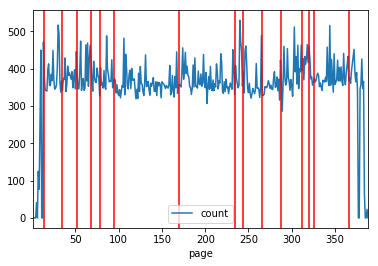

In [19]:
# Get just the page numbers from the search for each section
page_numbers = section_pages.index.get_level_values('page')

# Visualize the tokens-per-page from before
tokens.plot()

# Add vertical lines for pages with section breaks

for page_number in page_numbers:
    plt.axvline(x=page_number, color='red')

### Bonus: Sorting DataFrames 
A DataFrame can be sorted with `DataFrame.sort_values()`, specifying the column to sort by as the first argument. By default, sorting is done in ascending order:

In [20]:
tl_simple.sort_values('count').head()

count
section token         
body    ♦wenty       1
        bottle       1
        priming      1
        bosoms       1
        bosom        1

Descending order is possible with the argument `ascending=False`, which puts the most common tokens at the top. For example:

In [21]:
tl_simple.sort_values('count', ascending=False).head()

count
section token       
body    ,      11573
        the     9972
        of      6991
        .       4761
        and     3846

## Relative Frequencies and Stopword lists

Now we'll look at a look using relative frequencies. Relative frequencies are one way at looking at top words, through their proportional counts. Books have different lengths, so the nominal count of any given word will vary between books, so relative frequencies give us a way to compare two or more books.

Still looking at one volume, let's start to explore the relative frequencies of tokens within the volume. 

The following cell will display the most common tokens (words or punctuation marks) in a given volume, alongside the number of times they appear. It will also calculate their relative frequencies (found by dividing the number of appearances over the total number of words in the book) and display the results in a DataFrame. The cell may take a few seconds to run because we're looping through every word in the volume!

In [22]:
tokens = vol.tokenlist(pos=False, case=False, pages=False).sort_values('count', ascending=False)

freqs = []
for count in tokens['count']:
    freqs.append(count/sum(tokens['count'])) # generating a frequency by volume for a given token 
                                             # by counting it's frequency in the volume, and dividing 
                                             # by total tokens in the volume
    
tokens['rel_frequency'] = freqs
tokens

count  rel_frequency
section lowercase                         
body    ,             11573       0.082990
        the           11028       0.079082
        of             7035       0.050448
        .              4761       0.034141
        and            3874       0.027781
        to             3241       0.023241
        a              2283       0.016371
        in             2189       0.015697
        his            1784       0.012793
        ;              1280       0.009179
        was            1234       0.008849
        is             1201       0.008612
        by             1167       0.008369
        that           1114       0.007989
        he             1113       0.007981
        which          1105       0.007924
        "              1000       0.007171
        with            906       0.006497
        it              729       0.005228
        from            713       0.005113
        this            694       0.004977
        as              689       0.004941
        are             658       0.004719
        their           652       0.004676
        or              611       0.004381
        at              576       0.004131
        on              571       0.004095
        had             543       0.003894
        but             527       0.003779
        they            509       0.003650
...                     ...            ...
        narrowness        1       0.000007
        criticisms        1       0.000007
        neat              1       0.000007
        neat-looking      1       0.000007
        nee               1       0.000007
        creations         1       0.000007
        credentials       1       0.000007
        neigh             1       0.000007
        credible          1       0.000007
        credulous         1       0.000007
        negotiating       1       0.000007
        negotiated        1       0.000007
        negotiate         1       0.000007
        creeping          1       0.000007
        crept             1       0.000007
        needless          1       0.000007
        nedjed            1       0.000007
        neatest           1       0.000007
        nectarines        1       0.000007
        necromancers      1       0.000007
        necklace          1       0.000007
        nechus            1       0.000007
        nechua            1       0.000007
        necho             1       0.000007
        crippled          1       0.000007
        crisis            1       0.000007
        nebuzaradan       1       0.000007
        critical          1       0.000007
        nebo              1       0.000007
        ♦wenty            1       0.000007

[13524 rows x 2 columns]

Now, let's plot the most common tokens from the volume and their frequencies. The following cell outputs a bar plot using the matplotlib library.

Text(0.5, 1.0, 'Common token frequencies in "The modern traveller..."')

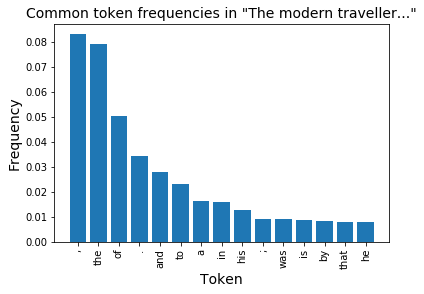

In [23]:
# First, we use a command that helps matplotlib plots better display in Jupyter
%matplotlib inline

# Build a list of frequencies and a list of tokens.
freqs_1, tokens_1 = [], []
for i in range(15):  # top 15 words
    freqs_1.append(freqs[i])
    tokens_1.append(tokens.index.get_level_values('lowercase')[i])

# Create a range for the x-axis
x_ticks = numpy.arange(len(tokens_1))

# Plot!
plt.bar(x_ticks, freqs_1)
plt.xticks(x_ticks, tokens_1, rotation=90)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Token', fontsize=14)
plt.title('Common token frequencies in "' + vol.title[:20] + '..."', fontsize=14)

As you can see, the most common tokens are mostly punctuation and basic words that don't provide context. Let's see if we can narrow our search to gain some more relevant insight. 

We can get a list of stopwords from the nltk library. Punctuation is in the string library. Let's import nltk and make the stopwords and punctuation accessible to us:

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rdubnic2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now that we have imported the nltk library and downloaded the stopwords module, we can look at what is included in each list:

In [25]:
from nltk.corpus import stopwords
from string import punctuation

print(f"Stopwords: \n {stopwords.words('english')}")

print()

print(f"Punctuation: \n {punctuation}")

Stopwords: 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

With these lists of words/characters to ignore in our DataFrame, we can make a few tweaks to our plotting cell to remove the punctuation and display only those words not in our stopword list:

Text(0.5, 1.0, 'Common token frequencies in "The modern traveller..."')

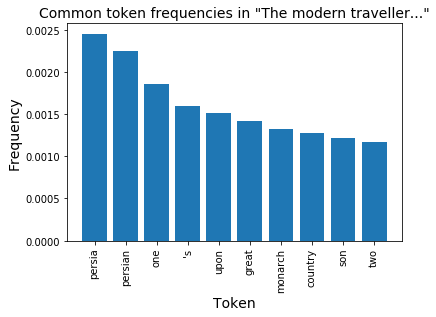

In [26]:
freqs_filtered, tokens_filtered, i = [], [], 0

while len(tokens_filtered) < 10:
    if tokens.index.get_level_values('lowercase')[i] not in stopwords.words('english') + list(punctuation):
        freqs_filtered.append(freqs[i])
        tokens_filtered.append(tokens.index.get_level_values('lowercase')[i])
    i += 1

# Create a range for the x-axis
x_ticks = numpy.arange(len(freqs_filtered))

# Plot!
plt.bar(x_ticks, freqs_filtered)
plt.xticks(x_ticks, tokens_filtered, rotation=90)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Token', fontsize=14)
plt.title('Common token frequencies in "' + vol.title[:20] + '..."', fontsize=14)

## Tokens from all volumes in our set

Now let's see how word frequencies compare across all the books in our samples. 

First we'll set-up a few functions. The first finds the most common noun in a volume, with adjustable parameters for minimum length. The second calculates the relative frequency of a token across all volumes in a FeatureReader collection, saving us the time of doing the calculation like in the above cell. Finally, we'll have a visualization function to create a bar plot of relative frequencies for all volumes in our sample, so that we can easily track how word frequencies differ across titles.

### Most common nouns

Let's see what the most common nouns in this work are by word length. To try, add a number to the second code box below.

NOTE: `word_length` defaults to 2. e.g. `most_common_noun(fr_novels.first)` returns 'time'.

In [27]:
#establishing the function used in the next box
def most_common_noun(vol, word_length=2):   
    # Build a table of common nouns
    tokens_1 = vol.tokenlist(pages=False, case=False) # create token list DF
    nouns_only = tokens_1.loc[(slice(None), slice(None), ['NN']),] # slice token list DF to get DF with only nouns
    top_nouns = nouns_only.sort_values('count', ascending=False) # sort the noun DF by highest count

    token_index = top_nouns.index.get_level_values('lowercase') # creating a new DF with token (here noun) frequency 
                                                                # as index
    
    # Choose the first token at least as long as word_length with non-alphabetical characters
    for i in range(max(token_index.shape)):
        if (len(token_index[i]) >= word_length):
            if("'", "!", ",", "?" not in token_index[i]):
                return token_index[i]
    print('There is no noun of this length')
    return None

In [28]:
#add a number to the parenthesis between the comma , and end parenthesis )
most_common_noun(vol, 10)
# most_common_noun(fr_mt.first(), 10) # the same as above, but using a FeatureReader collection instead of a variable

'government'

### Relative token frequency
Here, the function `frequency()` returns a plot of the usage frequencies of the given word across all volumes in the given FeatureReader collection (which could include one or more volumes).

NOTE: `frequency()` returns a dictionary entry of the form `{'word': frequency}`. e.g. `frequency(fr_novels.first(), 'blue')` returns `{'blue': 0.00012}`

Try adding a word in the single quotes in the last line below.

In [29]:
#establishing the function used in the next box
def frequency(vol, word):
    t1 = vol.tokenlist(pages=False, pos=False, case=False)
    token_index = t1[t1.index.get_level_values("lowercase") == word]
    
    if len(token_index['count'])==0:
        return {word: 0}
    
    count = token_index['count'][0]
    freq = count/sum(t1['count'])
    
    return {word: float('%.5f' % freq)} # '%.5f' means it'll return a float rounded to 5 decimal places

In [30]:
#add a word in the quotes below
frequency(vol, 'elephant')

{'elephant': 2e-05}

### Putting them together

The code below returns a plot of the usage frequencies of the given word across all volumes in the given FeatureReader collection.

Try adding different words to see their relative frequency in our sample.

NOTE: frequencies are given as percentages rather than true ratios.

In [31]:
#establishing the function used in the next box
def frequency_bar_plot(word, FR_col):
    freqs, titles = [], []
    for vol in FR_col:
        title = vol.title
        short_title = title[:6] + (title[6:] and '..')
        freqs.append(100*frequency(vol, word)[word]) # calling our frequency function
        titles.append(short_title)
        
    # Format and plot the data -- this replicates the code we used outside of the function in our bar chart above
    x_ticks = numpy.arange(len(titles))
    plt.bar(x_ticks, freqs)
    plt.xticks(x_ticks, titles, fontsize=10, rotation=90)
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Volume title', fontsize=12)
    plt.title('Frequency of "' + word + '"', fontsize=14)

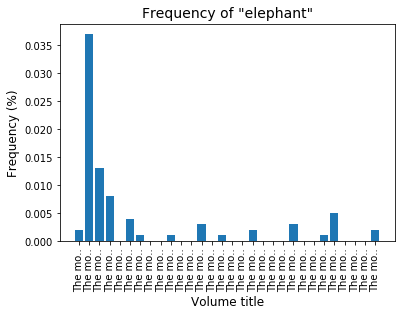

In [32]:
# add a word to between the quotes
frequency_bar_plot('elephant', fr_mt)

Okay, that's interesting, but since all our titles are the same, it's hard to make sense of the results. Let's try plotting relative frequency over time.

The code below returns a DataFrame of relative frequencies, volume years, and page counts, along with a scatter plot.

NOTE: frequencies are given in percentages rather than true ratios.

Try adding a word in the single quotes in the last line below.

In [33]:
# a function to visualize frequency by volume
def frequency_by_vol(query_word, FR_col):
    volumes = pandas.DataFrame()
    ids, page_counts, query_freqs = [], [], []

    for vol in FR_col:
        ids.append(vol.id)
        page_counts.append(int(vol.page_count))
        query_freqs.append(100*frequency(vol, query_word)[query_word])
    
    volumes['id'], volumes['pages'], volumes['freq'] = ids, page_counts, query_freqs
    volumes = volumes.sort_values('id')
    
    fig_plot = volumes.plot('id','freq', scalex=False)
    tick_labels = tuple(volumes['id'])
    x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
    x_min = int(min(plt.xticks()[0]))
    plt.xticks(range(x_min, x_max), tick_labels, rotation=90) 
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('HTID', fontsize=12)
    plt.title('Frequency of "' + query_word + '"', fontsize=14)
    
    return volumes.head(10)

# A bonus function that returns and plots frequences for a FR collection by volume year
def frequency_by_year(query_word, FR_col):
    volumes = pandas.DataFrame()
    years, page_counts, query_freqs = [], [], []

    for vol in FR_col:
        years.append(int(vol.year))
        page_counts.append(int(vol.page_count))
        query_freqs.append(100*frequency(vol, query_word)[query_word])
    
    volumes['year'], volumes['pages'], volumes['freq'] = years, page_counts, query_freqs
    volumes = volumes.sort_values('year')
    
    # Set plot dimensions and labels
    scatter_plot = volumes.plot.scatter('year', 'freq', color='black', s=50, fontsize=12)
    plt.ylim(0-numpy.mean(query_freqs), max(query_freqs)+numpy.mean(query_freqs))
    plt.ylabel('Frequency (%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.title('Frequency of "' + query_word + '"', fontsize=14)
    
    return volumes.head(10)

,id,pages,freq
29,mdp.39015073767215,360,0.002
28,mdp.39015073767751,394,0.000
27,mdp.39015073767769,386,0.000
26,mdp.39015073767777,394,0.000
25,mdp.39015073767785,340,0.005
24,mdp.39015073767801,372,0.001
23,mdp.39015073767827,394,0.000
22,mdp.39015073767835,392,0.000
21,mdp.39015073767843,356,0.003
20,mdp.39015073767850,360,0.000


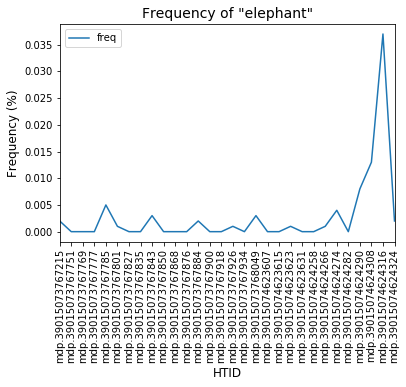

In [34]:
# replace the word between the quotes to try other terms

frequency_by_vol('elephant', fr_mt)

### Making use of the structured file

One particularly useful thing about the Extracted Features dataset is that the tokens in the extracted features files are part-of-speech tagged to differentiate homynyms like 'rose', which can be a name, a noun, and a verb.

For each page, the data is also divided into a header, body, and footer section so that you can systematically remove headers or footers from your data if you choose.

We already saw the possibiity of drilling down to the part-of-speech tag earlier when we found the most frequently-occuring noun in a volume. Below, we will look for one part of speech in just the body of our volumes.

What do you find? Try editing the code to retrieve tokens of another part of speech. Here are the codes in the Penn Treebank: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html. 

The code is set to retrieve only tokens that occured more than 50 times. Can you change the cut-off and see how it effects your results?

In [35]:
#list the most frequently occuring adjectives that occured more than 50 times in the data
idx = pandas.IndexSlice
vol = next(fr_mt.volumes())
tl = vol.tokenlist(pages=False)
tl.index = tl.index.droplevel(0)
adjectives = tl.loc[idx[:,('JJ')],]
adj_dfs = [adjectives for vol in fr_mt.volumes()]
all_adj = pandas.concat(adj_dfs).groupby(level='token').sum().sort_values('count', ascending=False)[:50]

# displays the first 25 rows of the Pandas dataframe of all adjectives
all_adj.head(25)

,count
token,
Persian,7380
great,5190
other,4890
first,3480
many,3000
same,2820
ancient,2670
own,2490
several,2400


### More frequency questions
Let's combine what we've learned and written to try to answer some specific questions. First, we'll define a number of variables that we will use later:

In [36]:
vol1 = fr_mt.first() # the first volume in our FR collection
tokens = vol1.tokenlist(pages=False, pos=False, case=False) # a token list created from that volume
tokens = tokens.loc['body'] # Only focus on section='body'

# removing stop words and non-alphabetical characters, such as punctuation and numbers:
subset1 = tokens[~tokens.index.isin(stopwords.words('english')) & tokens.index.str.isalpha()]

Another way to look at notable words is through parts-of-speech. e.g. focusing on `NNP` (proper nouns):

In [37]:
tokens = vol1.tokenlist(pages=False, pos=True, case=True).loc['body']
proper_nouns_v1 = tokens.loc[(slice(None), ('NNP')),].sort_values('count', ascending=False) # Select NNP and sort
proper_nouns_v1['rel_freq'] = proper_nouns_v1['count'] / proper_nouns_v1['count'].sum() # Calculate Relative frequency
proper_nouns_v1.head(5)

,,count,rel_freq
token,pos,,
Persia,NNP,332,0.035413
Sir,NNP,135,0.014400
Khan,NNP,134,0.014293
Shah,NNP,122,0.013013
Malcolm,NNP,116,0.012373


The value of relative frequencies is that it is easy to compare multiple books. First, let's load volume two of  _The Modern Traveller_ to compare:

In [38]:
vol2 = FeatureReader('ef-data/mdp.39015073767751.json.bz2').first()
tokens = vol2.tokenlist(pages=False, pos=True, case=True).loc['body']
proper_nouns_v2 = tokens.loc[(slice(None), ('NNP')),].sort_values('count', ascending=False)
proper_nouns_v2['rel_freq'] = proper_nouns_v2['count'] / proper_nouns_v2['count'].sum()

In [39]:
proper_nouns_v1.head(2)

,,count,rel_freq
token,pos,,
Persia,NNP,332,0.035413
Sir,NNP,135,0.014400


In [40]:
proper_nouns_v2.head(2)

,,count,rel_freq
token,pos,,
Mexico,NNP,333,0.047463
Cortes,NNP,241,0.034350


Since the index of 'token' and 'pos' is the same, you can just subtract one DataFrame from another and the code will know to align the rows (i.e. subtracting the `(Cape, NNP)` information). We can do this to see which tokens increased in usage from volume 1 to volume 2:

In [41]:
compare_vols = (proper_nouns_v2 - proper_nouns_v1)
compare_vols.sort_values('rel_freq', ascending=False).dropna()

,,count,rel_freq
token,pos,,
Humboldt,NNP,163.0,0.023268
Spain,NNP,112.0,0.015999
New,NNP,100.0,0.014397
Mr.,NNP,40.0,0.008606
Traveller,NNP,37.0,0.005668
Europe,NNP,33.0,0.005421
St,NNP,34.0,0.005097
Don,NNP,35.0,0.005024
Essay,NNP,29.0,0.004205


In the name of minimizing hassle, we've used our _The Modern Traveller_ workset again for this, but it's admittedly not the most interesting workset for this type of question, as each volume is focused on a different region of the world, as shown by 'Cape' and 'Mr.' -- the most frequent proper nouns in volume 1 -- shown here as having the largest drop in frequency when compared to volume 2.